Select "Runtime" -> "Change runtime type"
Change type to "GPU".

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir("/content/gdrive/My Drive/SSD_ADAS/ssd_keras/")
print("Working directory:", os.getcwd())

Working directory: /content/gdrive/My Drive/SSD_ADAS/ssd_keras


In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from eval_utils.average_precision_evaluator import Evaluator

Using TensorFlow backend.


In [0]:
img_height = 300
img_width = 300
n_classes = 80 # COCO classes
model_mode = 'training' # Do this even when evaluating.

# 1: Build the Keras model
K.clear_session() # Clear previous models from memory.
model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05], # COCO
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.
weights_path = '../pretrained_weights/VGG_coco_SSD_300x300_iter_400000.h5'
model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [9]:
!rm ~/validation.h5
!rm ~/training.h5

rm: cannot remove '/root/validation.h5': No such file or directory
rm: cannot remove '/root/training.h5': No such file or directory


In [10]:
# Make datagen

def make_h5_dataset(images_dir, annotation_csv, h5_filename):
  input_format = ["image_name", "class_id", "xmin", "xmax", "ymin", "ymax"] # order of columns in csv
  
  csv_dataset = DataGenerator()
  csv_dataset.parse_csv(
    images_dir,
    annotation_csv,
    input_format,
    verbose=False
    )
  
  csv_dataset.create_hdf5_dataset(
    h5_filename,
    resize=False,
    verbose=True)
  
  h5_dataset = DataGenerator(hdf5_dataset_path = h5_filename)
  return h5_dataset

import os

training_image_dir = "../FLIR_ADAS/training/PreviewData"
training_annotation_csv = "../training.csv"
h5_training_filename = os.path.expanduser("~/training.h5")

validation_image_dir = "../FLIR_ADAS/validation/PreviewData"
validation_annotation_csv = "../validation.csv"
h5_validation_filename = os.path.expanduser("~/validation.h5")

training_dataset = make_h5_dataset(training_image_dir, training_annotation_csv, h5_training_filename)
validation_dataset = make_h5_dataset(validation_image_dir, validation_annotation_csv, h5_validation_filename)

Loading image IDs: 100%|██████████| 1360/1360 [00:00<00:00, 6824.80it/s]


In [21]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
mean_color = [123, 117, 104]
scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5],
                         [1.0, 2.0, 0.5]]

two_boxes_for_ar1=True
steps=[8, 16, 32, 64, 100, 300]
offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
clip_boxes=False
variances=[0.1, 0.1, 0.2, 0.2]
normalize_coords=True


# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios_per_layer,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = training_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = validation_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = training_dataset.get_dataset_size()
val_dataset_size   = validation_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  7860
Number of images in the validation dataset:	  1360


In [0]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [0]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_test4_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd300_ADAS_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

In [24]:
import os
print(os.cpu_count())

2


In [25]:

# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 120
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch,
                              use_multiprocessing=True)

Epoch 1/120

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 2324s 2s/step - loss: 5.4450 - val_loss: 4.4095

Epoch 00001: val_loss improved from inf to 4.40952, saving model to ssd300_test4_epoch-01_loss-5.4457_val_loss-4.4095.h5
Epoch 2/120

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 2284s 2s/step - loss: 3.5839 - val_loss: 3.9000

Epoch 00002: val_loss improved from 4.40952 to 3.89997, saving model to ssd300_test4_epoch-02_loss-3.5839_val_loss-3.9000.h5
Epoch 3/120

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 2283s 2s/step - loss: 3.1130 - val_loss: 3.8558

Epoch 00003: val_loss improved from 3.89997 to 3.85585, saving model to ssd300_test4_epoch-03_loss-3.1129_val_loss-3.8558.h5
Epoch 4/120

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [================

Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/mu

Epoch 1/120


  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


Epoch 1/120


KeyboardInterrupt: ignored

In [0]:
# Create Evaluator instance, caching predictions
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=validation_dataset,
                      model_mode=model_mode)

In [27]:
# Evaluate the cached predictions
results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=64,
                    data_generator_mode='resize',
                    matching_iou_threshold=0.5,
                    average_precision_mode='integrate',
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 1360

Producing predictions batch-wise: 100%|██████████| 22/22 [02:58<00:00,  6.33s/it]
Matching predictions to ground truth, class 1/80.: 100%|██████████| 86378/86378 [00:11<00:00, 7437.42it/s]
Matching predictions to ground truth, class 2/80.: 100%|██████████| 18597/18597 [00:01<00:00, 13985.59it/s]
Matching predictions to ground truth, class 3/80.: 100%|██████████| 164493/164493 [00:22<00:00, 7312.08it/s]
No predictions for class 4/80
No predictions for class 5/80
No predictions for class 6/80
No predictions for class 7/80
No predictions for class 8/80
No predictions for class 9/80
No predictions for class 10/80
No predictions for class 11/80
No predictions for class 12/80
No predictions for class 13/80
No predictions for class 14/80
No predictions for class 15/80
No predictions for class 16/80
Matching predictions to ground truth, class 17/80.: 100%|██████████| 2532/2532 [00:00<00:00, 26397.63it/s]
No predictions for class 18/80
No predic

In [29]:
classes_of_interest = {1:"person", 2:"bicycle/motorbike", 3:"car", 17:"dog"}

for class_id in classes_of_interest.keys():
    print("{:<20} AP: {:<8} ".format(classes_of_interest[class_id], average_precisions[class_id], ))
    
main_classes_AP = np.mean((average_precisions[1], average_precisions[2], average_precisions[3]))
print("Main classes mAP:", main_classes_AP)

person               AP: 0.3853385099607306 
bicycle/motorbike    AP: 0.1756310680754122 
car                  AP: 0.6677409393429259 
dog                  AP: 0.007518796992481203 
Main classes mAP: 0.4095701724596896


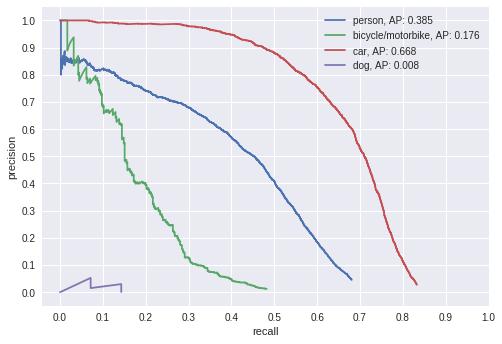

In [31]:
def plot_PRs(class_ids):
  plt.figure()
  
  for class_id in class_ids:
    plt.plot(
        recalls[class_id],
        precisions[class_id],
        label = "{}, AP: {:.3f}".format(classes_of_interest[class_id], average_precisions[class_id]))
    
  #plt.xlim((0,1))
  #plt.ylim((0,1))
  plt.xticks(np.linspace(0,1,11))
  plt.yticks(np.linspace(0,1,11))
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend()
  return
    
plot_PRs(classes_of_interest.keys())

In [0]:
!df -h /tmp

In [0]:
!pwd

In [0]:
!echo ~

In [0]:
ls /root